# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from IPython.display import clear_output

import world

%matplotlib inline


def pretty_print(obj):
    print(json.dumps(third_person_brain_state_ontology, indent=2, sort_keys=True))

# 3rd-person (objective) perspective

## The world and an agent acting in the world

### Intuition for the world

[OpenAI's LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)
- The agent is a lunar lander attempting to softly land between the flags
- Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points
- Each leg ground contact is +10
- Firing the engines is a small negative reward
- Small positive reward for smoother flight
- Fuel is infinite
- Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine

In [2]:
%%HTML
<video width="480" height="360" controls>
  <source src="../openai_lunarlander_video.mp4" type="video/mp4">
</video>

### Intuition for how agents are described

In [3]:
# An agent that does nothing

class DoNothingAgent(object):

    def act(self, observation):
        return 0
    
agent = DoNothingAgent()
episode_history = world.run_episode(agent)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved -136 total reward


In [4]:
# An agent that takes random actions

class RandomAgent(object):

    def act(self, observation):
        return random.randint(0, 3)

agent = RandomAgent()
episode_history = world.run_episode(agent)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved -72 total reward


## An agent who performs well in the world

In [5]:
from training import train_agent, load_pretrained_agent

# Uncomment below if you wish to retrain the agent, otherwise it will use a pretrained, saved model
# train_agent()

agent = load_pretrained_agent()

In [6]:
episode_history = world.run_episode(agent)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved 249 total reward


## A 3rd-person ontology over brain states

Brain state in humans and animals: the full physical-chemical state of the brain and nervous system

In [7]:
from brain_utils import third_person_brain_state_ontology

In [8]:
def print_ontology(onto):
    for type_name, python_type in onto.items():
        print('{}: {}'.format(type_name, python_type))

In [9]:
print_ontology(third_person_brain_state_ontology)

activations: <class 'list'>
action: <class 'numpy.int64'>
observation: <built-in function array>
layer_weights: <class 'list'>


## Some brain state tokens of the agent

In [10]:
from world_utils import visualize_world
from brain_utils import get_brain_state, visualize_weights, visualize_activations


def visualize_third_person_brain_state_token(episode_index):

    brain_state = get_brain_state(agent, episode_history['observation'][episode_index])

    visualize_world(episode_history['world_image'][episode_index])
    visualize_weights(brain_state)
    visualize_activations(brain_state)

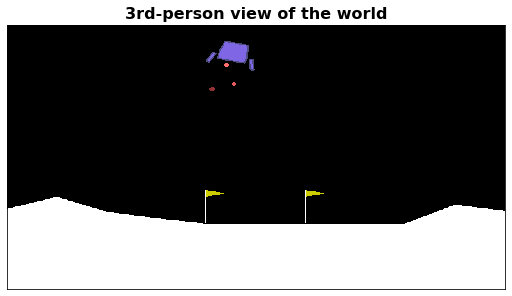

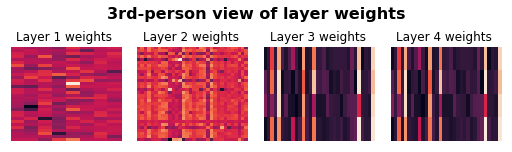

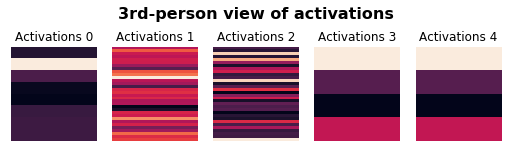

In [11]:
visualize_third_person_brain_state_token(50)

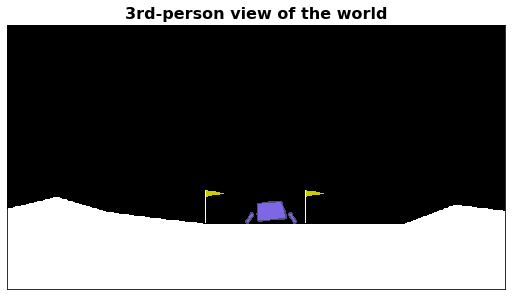

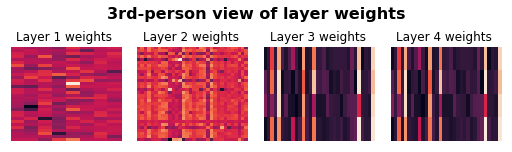

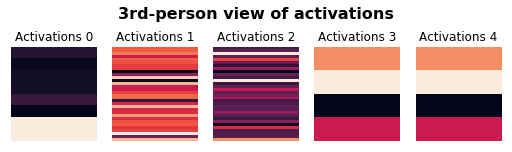

In [12]:
visualize_third_person_brain_state_token(300)

# 1st-person (subjective) perspective

## Semantically important areas for the agent (viewed from the 3rd-person perspective)

In [13]:
def high(observation):
    return observation[1] > 0.2

def low(observation):
    return observation[1] <= 0.2

def left(observation):
    return observation[0] < -0.2

def right(observation):
    return observation[0] > 0.2

def middle(observation):
    return abs(observation[0]) < 0.2

important_areas = [high, low, left, right, middle]

In [14]:
def print_matching_area(observation):
    for area in important_areas:
        print('{}: {}'.format(area.__name__, area(episode_history['observation'][episode_index])))

high: True
low: False
left: False
right: True
middle: False


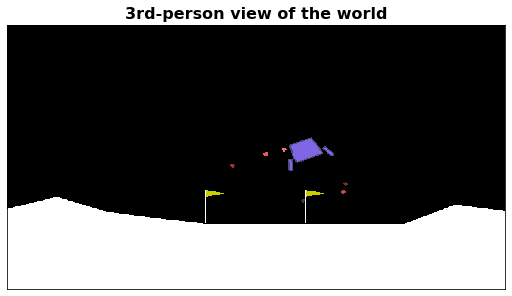

In [15]:
episode_index = 155

visualize_world(episode_history['world_image'][episode_index])

print_matching_area(episode_history['observation'][episode_index])

high: False
low: True
left: False
right: False
middle: True


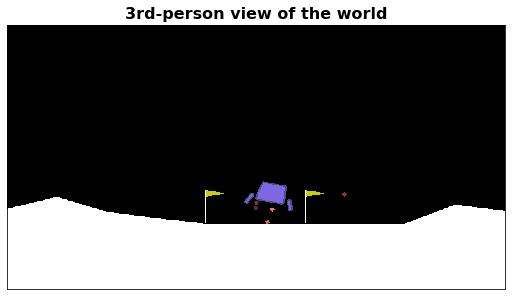

In [16]:
episode_index = 225

visualize_world(episode_history['world_image'][episode_index])

print_matching_area(episode_history['observation'][episode_index])

## A 1st-person ontology over mental states

Mental state in humans and animals: beliefs, desires, thoughts, perceptions, emotions, knowledge, etc.

In [17]:
class area_set(object):
    
    def __init__(self):
        self.areas = set()
        
    def __repr__(self):
        return str(sorted(self.areas))
    
    def add_area(self, area):
        self.areas.add(area)

first_person_mental_state_ontology = {
    'areas': area_set
}

## Conversion of brain states to mental states

In [18]:
def brain_state_to_mental_state(brain_state):
    mental_state = {k: v() for k, v in first_person_mental_state_ontology.items()}
    for i, area in enumerate(important_areas):
        if brain_state['activations'][2][i] > 0.5:
            mental_state['areas'].add_area(area.__name__)
    return mental_state

## Some mental state tokens of the agent

In [29]:
def report_mental_state(mental_state):
    print("""3rd-person report of the 1st-person view: 
    'I have the beliefs: {}'""".format(', '.join(mental_state['areas'].areas)))
    
def visualize_first_person_mental_state_token(episode_index):
    
    brain_state = get_brain_state(agent, episode_history['observation'][episode_index])

    mental_state = brain_state_to_mental_state(brain_state)

    report_mental_state(mental_state)
    
    visualize_world(episode_history['world_image'][episode_index])

3rd-person report of the 1st-person view: 
    'I have the beliefs: left, middle'


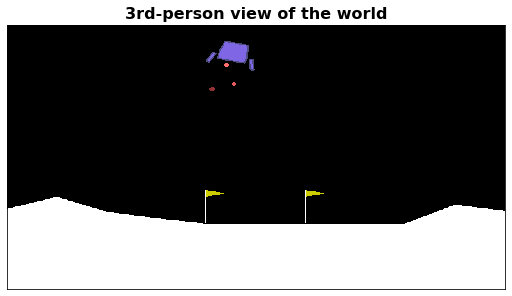

In [32]:
visualize_first_person_mental_state_token(50)

3rd-person report of the 1st-person view: 
    'I have the beliefs: left, middle'


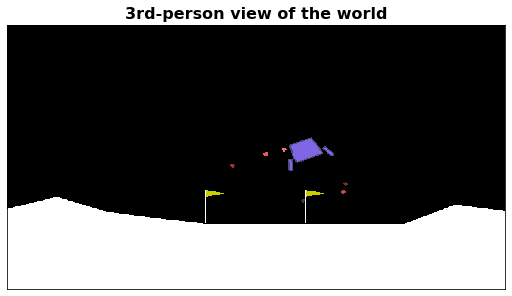

In [33]:
visualize_first_person_mental_state_token(155)

3rd-person report of the 1st-person view: 
    'I have the beliefs: left, middle'


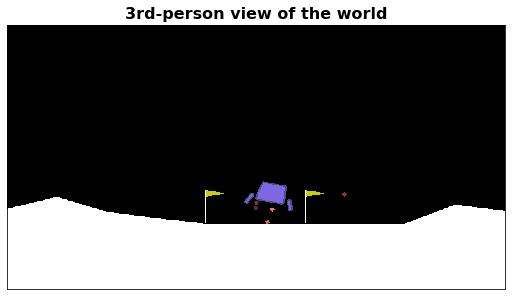

In [34]:
visualize_first_person_mental_state_token(225)

# Searle's view

- Mental state types are causally reducible to brain state types
- Mental state types are ontologically irreducible to brain state types

## Causal reducibility

Phenomena of type A are causally reducible to phenomena of type B if and only if
1. the behavior of A’s are entirely casually explained by the behavior of B’s
1. A’s have no causal powers in addition to the powers of B’s

### The agent's mental state behavior is causally explained by its brain states behavior

The function `brain_state_to_mental_state` is explicitly satisfying this.

### The agent's mental states have no causal powers in addition to the powers of its brain states

By looking at the neural network structure we can see all of the causal power is captured by the activations.

## Ontological irreducibility

Phenomena of type A are ontologically reducible to phenomena of type B if and only if A’s are nothing but B’s

### The agent's mental states are not nothing but its brain states

In [35]:
print_ontology(first_person_mental_state_ontology)

areas: <class '__main__.area_set'>


In [36]:
print_ontology(third_person_brain_state_ontology)

activations: <class 'list'>
action: <class 'numpy.int64'>
observation: <built-in function array>
layer_weights: <class 'list'>


# Open questions

One of the contentious pieces of this was the `brain_state_to_mental_state` function. A function that went from brain state types to mental state types. One way we can see even more clearly what is happening here is to note that this notebook is essentially the same argument as:

In [ ]:
brain_state = np.array([[2], [1]])
brain_state_to_mental_state_matrix = np.matrix([[1, 0], [0, 1], [1, 1]])
mental_state = brain_state_to_mental_state_matrix * brain_state

print('Brain state: \n{}\n'.format(brain_state))
print('Brain state to mental state "function": \n{}\n'.format(brain_state_to_mental_state_matrix))
print('Mental state: \n{}\n'.format(mental_state))

And then noting that:
- The "mental state" was created by a simple matrix multiplication with the "brain state" (hence, causally reducible)
- The "brain state" is of type length-2-vector and the "mental state" of type length-3-vector where there is one ontology over length-2-vectors and another ontology over length-3-vectors

So we'd be very curious to get thoughts on what this type conversion _means_ in the context of Searle's view (or even more broadly). Or is this confusion because we viewed (and implemented) `brain_state_to_mental_state` as a function and should have gone about that specifying that relationship another way?